Author: Jonathan Gong

In [1]:
import pandas as pd
import os
import sys
from sktime.annotation.hmm_learn import GMMHMM 
import numpy as np


# TODO 
- interpolate data so the bgl level readings are recorded at equal time intervals

# Data processing

In [2]:
csv_files = []
for file in os.listdir('../data/raw'):
    if file.endswith('.csv'):
        csv_files.append(pd.read_csv(f'../data/raw/{file}'))

/var/folders/22/0fj82gz10j5cvdcxtqcw5yc80000gn/T/ipykernel_97377/895166927.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  csv_files.append(pd.read_csv(f'../data/raw/{file}'))


In [502]:
each_bgl =[]
for file in csv_files:
    each_df = file[["date", "bgl"]]
    each_df["date"] = pd.to_datetime(each_df["date"], format='mixed', utc=True)
    each_bgl.append(each_df.dropna(subset=["bgl"], how='all'))

/var/folders/22/0fj82gz10j5cvdcxtqcw5yc80000gn/T/ipykernel_97377/4223640982.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  each_df["date"] = pd.to_datetime(each_df["date"], format='mixed', utc=True)
/var/folders/22/0fj82gz10j5cvdcxtqcw5yc80000gn/T/ipykernel_97377/4223640982.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  each_df["date"] = pd.to_datetime(each_df["date"], format='mixed', utc=True)


In [503]:
each_bgl[0].set_index('date', inplace=True)
df_resampled_0 = each_bgl[0].resample('5min').mean().interpolate(method='linear')

In [504]:
each_bgl[1].set_index('date', inplace=True)
df_resampled_1 = each_bgl[1].resample('5min').mean().interpolate(method='linear')

In [505]:
df_resampled_0

,bgl
date,
2024-07-01 05:00:00+00:00,98.0
2024-07-01 05:05:00+00:00,100.0
2024-07-01 05:10:00+00:00,98.0
2024-07-01 05:15:00+00:00,94.0
2024-07-01 05:20:00+00:00,94.0
...,...
2024-10-01 04:35:00+00:00,92.5
2024-10-01 04:40:00+00:00,87.0
2024-10-01 04:45:00+00:00,88.0


In [ ]:
# days_patients = []
# for bgl in each_bgl:
#     # (hour:minute:second)
#     bgl['time'] = bgl['date'].dt.time
#     # (year-month-day)
#     bgl['day'] = bgl['date'].dt.date
#     # unique days
#     unique_days = bgl['day'].unique()
#     day_data = []
#     for i, day in enumerate(unique_days):
#         bgl_day = bgl[bgl['day'] == day]
#         day_data.append(bgl_day["bgl"])

#     days_patients.append(day_data)

In [600]:
sequences = df_resampled_1["bgl"].to_numpy()
sequences = sequences.reshape(-1, 1)

In [507]:
len(sequences)

26496

In [601]:
justnorm_sequences = sequences/max(sequences)

In [602]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(sequences)

In [624]:
from sklearn.cluster import KMeans
data_used = scaled_data
n_components = 2 # Number of components in the GMMHMM
kmeans = KMeans(n_clusters=n_components).fit(data_used)
initial_means = kmeans.cluster_centers_

In [553]:
initial_means

array([[0.2734143 ],
       [0.41113593]])

# Model training and eval

In [625]:
n_components = 2
model = GMMHMM(n_components=n_components, n_mix = 2, covariance_type = 'full', n_iter = 100, verbose=True)
model.startprob_ = np.array([0.5, 0.5])
model.means_ = initial_means
model.fit(data_used)

         1  -66294.38587971             +nan
         2  -25567.55553585  +40726.83034387
         3  -29680.95006715   -4113.39453131
Model is not converging.  Current: -29680.950067150698 is not greater than -25567.555535845248. Delta is -4113.39453130545


GMMHMM(covariance_type='full', n_components=2, n_iter=100, n_mix=2,
       verbose=True)

In [626]:
hidden_states = model.predict(data_used)

In [627]:
np.unique(hidden_states) #im gna kill myself please for the love of god be smth different

array([0])

In [607]:
hidden_states

array([1, 1, 1, ..., 1, 1, 1])

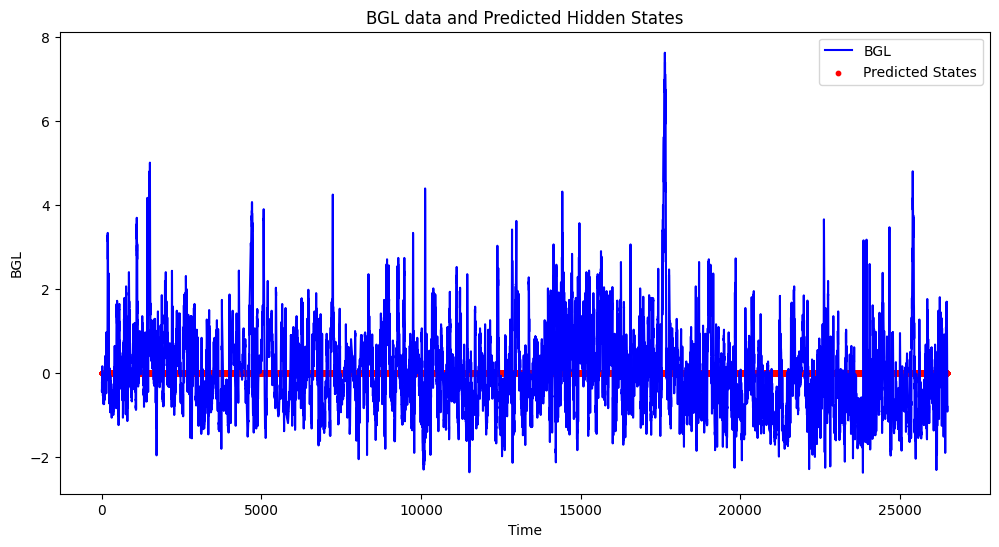

In [628]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(12, 6))
plt.plot(data_used, label='BGL', color='blue')
plt.scatter(range(len(hidden_states)), hidden_states, c='red', label='Predicted States', s=10)
plt.title("BGL data and Predicted Hidden States")
plt.xlabel("Time")
plt.ylabel("BGL")
plt.legend()
plt.show()